# Create minimal training and validation data


In [1]:
# Import Python libraries and set environment variables:

In [2]:
import os, json, math, shutil
import numpy as np
import tensorflow as tf
!sudo apt install graphviz -y

# environment variables used by bash cells
PROJECT=!(gcloud config get-value project)
PROJECT=PROJECT[0]

REGION = 'us-central1'
BUCKET='{}-dsongcp'.format(PROJECT)
os.environ['ENDPOINT_NAME'] = 'flights'

os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TF_VERSION']='2-' + tf.__version__[2:4]

2025-12-09 01:00:42.855212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-09 01:00:44.141256: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-12-09 01:00:44.141375: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-5+deb11u1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [3]:
#Create training dataset flights_train_data for model training:

In [4]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_train_data AS

SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND
  f.DIVERTED = False AND
  is_train_day = 'True'

Query is running:   0%|          |

""


In [5]:
#Create the evaluation dataset flights_eval_data for model evaluation:

In [6]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_eval_data AS

SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND
  f.DIVERTED = False AND
  is_train_day = 'False'

Query is running:   0%|          |

""


In [7]:
#Create the full dataset flights_all_data using the following code:

In [8]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_all_data AS

SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon,
  IF (is_train_day = 'True',
      IF(ABS(MOD(FARM_FINGERPRINT(CAST(f.FL_DATE AS STRING)), 100)) < 60, 'TRAIN', 'VALIDATE'),
      'TEST') AS data_split
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND
  f.DIVERTED = False

Query is running:   0%|          |

""


In [9]:
'''Export the training, validation, and full datasets to CSV file format the Google Cloud Storage bucket:
This will take about 2 minutes to complete.

Wait until you receive output from running the following bash script in your notebook cell:
'''

'Export the training, validation, and full datasets to CSV file format the Google Cloud Storage bucket:\nThis will take about 2 minutes to complete.\n\nWait until you receive output from running the following bash script in your notebook cell:\n'

In [10]:
%%bash
PROJECT=$(gcloud config get-value project)
for dataset in "train" "eval" "all"; do
  TABLE=dsongcp.flights_${dataset}_data
  CSV=gs://${BUCKET}/ch9/data/${dataset}.csv
  echo "Exporting ${TABLE} to ${CSV} and deleting table"
  bq --project_id=${PROJECT} extract --destination_format=CSV $TABLE $CSV
  bq --project_id=${PROJECT} rm -f $TABLE
done

Exporting dsongcp.flights_train_data to gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/data/train.csv and deleting table


Waiting on bqjob_r74eb743e5cad8922_0000019b00a04608_1 ... (65s) Current status: DONE   


Exporting dsongcp.flights_eval_data to gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/data/eval.csv and deleting table


Waiting on bqjob_r26bc697e0d83054a_0000019b00a15c62_1 ... (14s) Current status: DONE   


Exporting dsongcp.flights_all_data to gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/data/all.csv and deleting table


Waiting on bqjob_r7d7f9857c906239a_0000019b00a1adc3_1 ... (65s) Current status: DONE   


In [11]:
#List exported objects to Google Cloud Storage bucket using the following code:

In [12]:
!gsutil ls -lh gs://{BUCKET}/ch9/data

445.01 MiB  2025-12-09T01:03:29Z  gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/data/all.csv
115.19 MiB  2025-12-09T01:02:26Z  gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/data/eval.csv
296.96 MiB  2025-12-09T01:02:00Z  gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/data/train.csv
TOTAL: 3 objects, 898801258 bytes (857.16 MiB)


# Create the input data

### Setup in notebook

In [13]:
#For development purposes, train for a few epochs. That's why the NUM_EXAMPLES is so low.

In [14]:
DEVELOP_MODE = True
NUM_EXAMPLES = 5000*1000

In [15]:
#Assign your training and validation data URI to training_data_uri and validation_data_uri respectively:

In [16]:
training_data_uri = 'gs://{}/ch9/data/train*'.format(BUCKET)
validation_data_uri = 'gs://{}/ch9/data/eval*'.format(BUCKET)

In [17]:
#Set up Model Parameters using the following code-block:

In [18]:
NBUCKETS = 5
NEMBEDS = 3
TRAIN_BATCH_SIZE = 64
DNN_HIDDEN_UNITS = '64,32'

### Reading data into TensorFlow

In [19]:
#To read the CSV files from Google Cloud Storage into TensorFlow, use a method from the tf.data package:

In [20]:
if DEVELOP_MODE:
    train_df = tf.data.experimental.make_csv_dataset(training_data_uri, batch_size=5)
    for n, data in enumerate(train_df):
        numpy_data = {k: v.numpy() for k, v in data.items()}
        print(n, numpy_data)
        if n==1: break

2025-12-09 01:03:45.783064: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-12-09 01:03:45.783111: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-12-09 01:03:45.783144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20251208-190921): /proc/driver/nvidia/version does not exist
2025-12-09 01:03:45.783715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable the

0 {'ontime': array([1, 1, 1, 1, 0], dtype=int32), 'dep_delay': array([-7, -8, -6,  9, -5], dtype=int32), 'taxi_out': array([11, 14,  7,  8, 16], dtype=int32), 'distance': array([2466, 2677,  100,  479, 2486], dtype=int32), 'origin': array([b'SJC', b'SEA', b'OGG', b'SMF', b'LAX'], dtype=object), 'dest': array([b'LIH', b'HNL', b'HNL', b'PDX', b'OGG'], dtype=object), 'dep_hour': array([13, 16,  6, 20, 18], dtype=int32), 'is_weekday': array([1, 1, 1, 0, 1], dtype=int32), 'carrier': array([b'AS', b'AS', b'HA', b'WN', b'HA'], dtype=object), 'dep_airport_lat': array([37.362778, 47.45    , 20.898611, 38.695557, 33.9425  ],
      dtype=float32), 'dep_airport_lon': array([-121.92917 , -122.31167 , -156.43056 , -121.590836, -118.40806 ],
      dtype=float32), 'arr_airport_lat': array([21.97611 , 21.317778, 21.317778, 45.58861 , 20.898611],
      dtype=float32), 'arr_airport_lon': array([-159.33888, -157.92027, -157.92027, -122.59695, -156.43056],
      dtype=float32)}
1 {'ontime': array([1, 1, 1,

#### Write features_and_labels() and read_dataset() functions. The read_dataset() function reads the training data, yielding batch_size examples each time, and allows you to stop iterating once a certain number of examples have been read.

#### The dataset contains all the columns in the CSV file, named according to the header line. The data consists of both features and the label. It’s better to separate them by writing the features_and_labels() function to make the later code easier to read. Hence, we’ll apply a pop() function to the dictionary and return a tuple of features and labels).

In [21]:
def features_and_labels(features):
  label = features.pop('ontime')
  return features, label

def read_dataset(pattern, batch_size, mode=tf.estimator.ModeKeys.TRAIN, truncate=None):
  dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size, num_epochs=1)
  dataset = dataset.map(features_and_labels)
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(batch_size*10)
    dataset = dataset.repeat()
  dataset = dataset.prefetch(1)
  if truncate is not None:
    dataset = dataset.take(truncate)
  return dataset


if DEVELOP_MODE:
    print("Checking input pipeline")
    one_item = read_dataset(training_data_uri, batch_size=2, truncate=1)
    print(list(one_item)) # should print one batch of 2 items

Checking input pipeline
[(OrderedDict([('dep_delay', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([10, 28], dtype=int32)>), ('taxi_out', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([25, 10], dtype=int32)>), ('distance', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1533,  100], dtype=int32)>), ('origin', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'SEA', b'HNL'], dtype=object)>), ('dest', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'FAI', b'OGG'], dtype=object)>), ('dep_hour', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([6, 4], dtype=int32)>), ('is_weekday', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 1], dtype=int32)>), ('carrier', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'AS', b'HA'], dtype=object)>), ('dep_airport_lat', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([47.45    , 21.317778], dtype=float32)>), ('dep_airport_lon', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-122.31167, -157.92027], dtype=float32)>), ('arr

# Create, train and evaluate TensorFlow model

#### Typically you create one feature for every column in our tabular data. Keras supports feature columns, opening up the ability to represent structured data using standard feature engineering techniques like embedding, bucketizing, and feature crosses. As numeric data can be passed in directly to the ML model, keep the real-valued columns separate from the sparse (or string) columns:

In [22]:
import tensorflow as tf

real = {
    colname : tf.feature_column.numeric_column(colname)
          for colname in
            (
                'dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
                'dep_airport_lat,dep_airport_lon,' +
                'arr_airport_lat,arr_airport_lon'
            ).split(',')
}
sparse = {
      'carrier': tf.feature_column.categorical_column_with_vocabulary_list('carrier',
                  vocabulary_list='AS,VX,F9,UA,US,WN,HA,EV,MQ,DL,OO,B6,NK,AA'.split(',')),
      'origin' : tf.feature_column.categorical_column_with_hash_bucket('origin', hash_bucket_size=1000),
      'dest'   : tf.feature_column.categorical_column_with_hash_bucket('dest', hash_bucket_size=1000),
}

#### All these features come directly from the input file (and are provided by any client that wants a prediction for a flight). Input layers map 1:1 to the input features and their types, so rather than repeat the column names, you create an input layer for each of these columns, specifying the right data type (either a float or a string).

In [23]:
inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string')
          for colname in sparse.keys()
})

### Bucketing


#### Real-valued columns whose precision is overkill (thus, likely to cause overfitting) can be discretized and made into categorical columns. For example, if you have a column for the age of the aircraft, you might discretize into just three bins—less than 5 years old, 5 to 20 years old, and more than 20 years old. Use the discretization shortcut: you can discretize the latitudes and longitudes and cross the buckets—this results in breaking up the country into grids and yield the grid point into which a specific latitude and longitude falls.

In [24]:
latbuckets = np.linspace(20.0, 50.0, NBUCKETS).tolist()  # USA
lonbuckets = np.linspace(-120.0, -70.0, NBUCKETS).tolist() # USA
disc = {}
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], latbuckets)
          for key in ['dep_airport_lat', 'arr_airport_lat']
})
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], lonbuckets)
          for key in ['dep_airport_lon', 'arr_airport_lon']
})

# cross columns that make sense in combination
sparse['dep_loc'] = tf.feature_column.crossed_column(
    [disc['d_dep_airport_lat'], disc['d_dep_airport_lon']], NBUCKETS*NBUCKETS)
sparse['arr_loc'] = tf.feature_column.crossed_column(
    [disc['d_arr_airport_lat'], disc['d_arr_airport_lon']], NBUCKETS*NBUCKETS)
sparse['dep_arr'] = tf.feature_column.crossed_column([sparse['dep_loc'], sparse['arr_loc']], NBUCKETS ** 4)

# embed all the sparse columns
embed = {
       'embed_{}'.format(colname) : tf.feature_column.embedding_column(col, NEMBEDS)
          for colname, col in sparse.items()
}
real.update(embed)

# one-hot encode the sparse columns
sparse = {
    colname : tf.feature_column.indicator_column(col)
          for colname, col in sparse.items()
}

if DEVELOP_MODE:
    print(sparse.keys())
    print(real.keys())

dict_keys(['carrier', 'origin', 'dest', 'dep_loc', 'arr_loc', 'dep_arr'])
dict_keys(['dep_delay', 'taxi_out', 'distance', 'dep_hour', 'is_weekday', 'dep_airport_lat', 'dep_airport_lon', 'arr_airport_lat', 'arr_airport_lon', 'embed_carrier', 'embed_origin', 'embed_dest', 'embed_dep_loc', 'embed_arr_loc', 'embed_dep_arr'])


### Train and evaluate the model

In [25]:
# Save the checkpoint:

In [26]:
output_dir='gs://{}/ch9/trained_model'.format(BUCKET)
os.environ['OUTDIR'] = output_dir  # needed for deployment
print('Writing trained model to {}'.format(output_dir))

Writing trained model to gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model


In [27]:
# Delete the model checkpoints already present in the storage bucket:

In [28]:
!gsutil -m rm -rf $OUTDIR

Removing gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/#1765240338594279...
Removing gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/checkpoints/#1765240338748318...
Removing gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/checkpoints/checkpoint#1765240347499836...
Removing gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/checkpoints/flights.cpt.data-00000-of-00001#1765240346831346...
Removing gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/checkpoints/flights.cpt.index#1765240347028937...
Removing gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/export/#1765240412951508...
Removing gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/export/flights_20251209-003324/#1765240413110908...
Removing gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/export/flights_20251209-003324/fingerprint.pb#1765240416177324...
Removing gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/export/flights_2025120

#### This reports an error stating CommandException: 1 files/objects could not be removed because the model has not yet been saved. The error indicates that there are no files present in the target location. You must be certain that this location is empty before attempting to save the model and this command guarantees that.



In [29]:
#With the sparse and real feature columns thus enhanced beyond the raw inputs, you can create a wide_and_deep_classifier passing in the linear and deep feature columns separately:

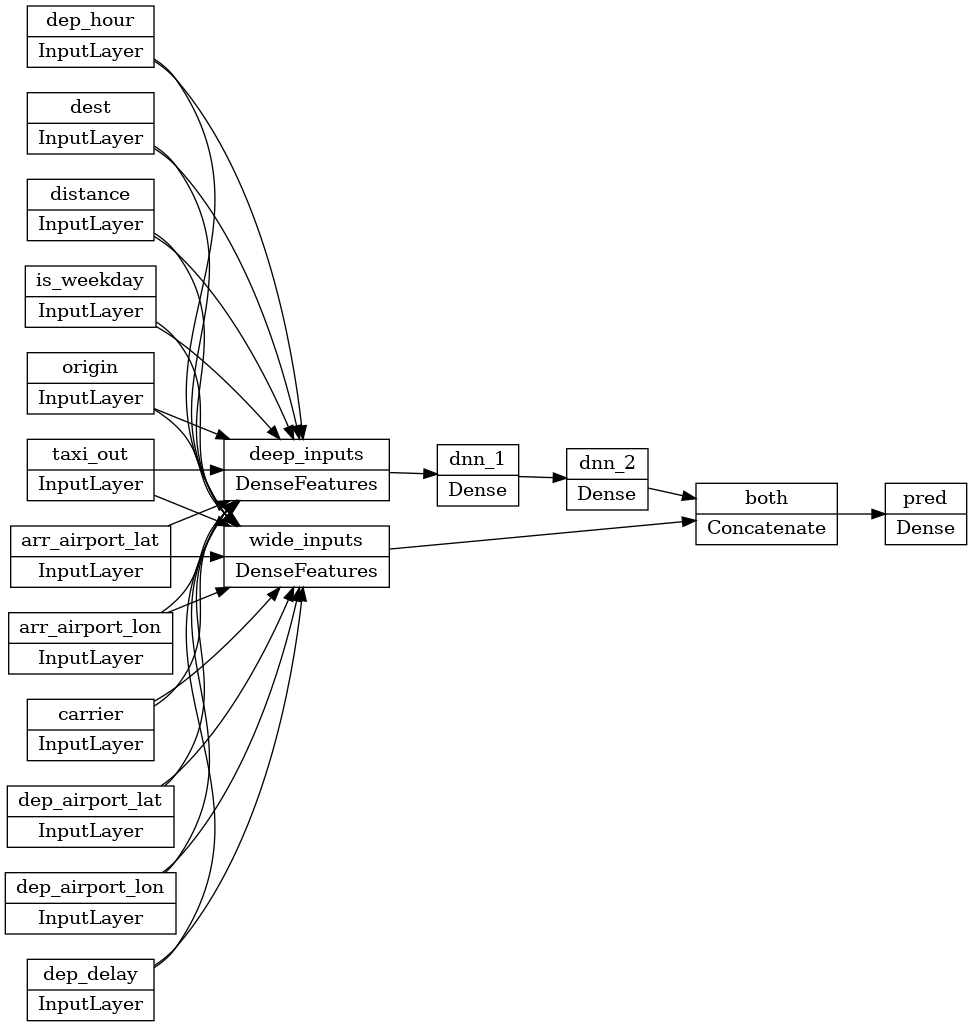

In [30]:
# Build a wide-and-deep model.
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns, name='deep_inputs')(inputs)
    layers = [int(x) for x in dnn_hidden_units.split(',')]
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = wide_and_deep_classifier(
    inputs,
    linear_feature_columns = sparse.values(),
    dnn_feature_columns = real.values(),
    dnn_hidden_units = DNN_HIDDEN_UNITS)
tf.keras.utils.plot_model(model, 'flights_model.png', show_shapes=False, rankdir='LR')

#### Use train_dataset for model training and eval_dataset for model evaluation.

In [31]:
#Create the model using the following code-blocks:

In [32]:
# training and evaluation dataset
train_batch_size = TRAIN_BATCH_SIZE
if DEVELOP_MODE:
    eval_batch_size = 100
    steps_per_epoch = 3
    epochs = 2
    num_eval_examples = eval_batch_size*10
else:
    eval_batch_size = 100
    steps_per_epoch = NUM_EXAMPLES // train_batch_size
    epochs = 10
    num_eval_examples = eval_batch_size * 100
train_dataset = read_dataset(training_data_uri, train_batch_size)
eval_dataset = read_dataset(validation_data_uri, eval_batch_size, tf.estimator.ModeKeys.EVAL, num_eval_examples)

checkpoint_path = '{}/checkpoints/flights.cpt'.format(output_dir)
shutil.rmtree(checkpoint_path, ignore_errors=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_dataset,
                    validation_data=eval_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[cp_callback])

Epoch 1/2
1/3 [=========>....................] - ETA: 10s - loss: 4.3344 - accuracy: 0.8750
Epoch 1: saving model to gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/checkpoints/flights.cpt
3/3 [==============================] - 15s 5s/step - loss: 3.8972 - accuracy: 0.7969 - val_loss: 2.0698 - val_accuracy: 0.7782
Epoch 2/2
1/3 [=========>....................] - ETA: 0s - loss: 1.2997 - accuracy: 0.8438
Epoch 2: saving model to gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/checkpoints/flights.cpt
3/3 [==============================] - 7s 3s/step - loss: 1.1760 - accuracy: 0.6823 - val_loss: 1.1966 - val_accuracy: 0.4027


In [33]:
#Visualize the model loss and model accuracy using matplotlib.pyplot:

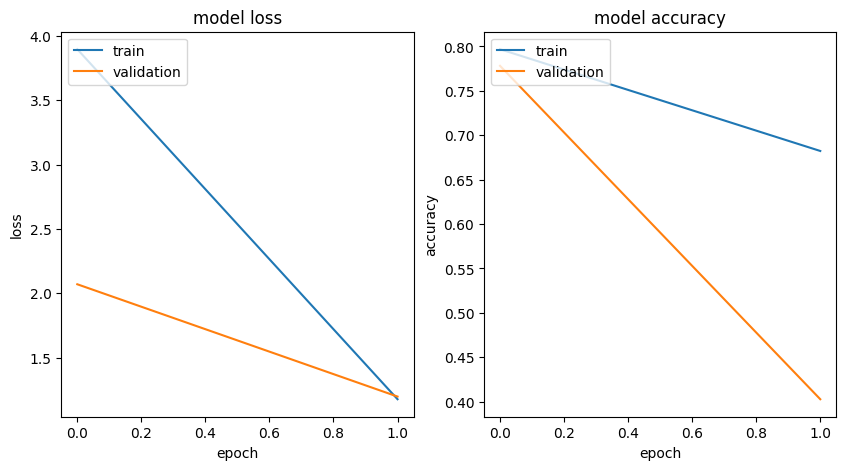

In [34]:
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'accuracy']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

### Export the trained model

In [35]:
#Save the model artifacts to the Google Cloud Storage bucket:

In [36]:
import time
export_dir = '{}/export/flights_{}'.format(output_dir, time.strftime("%Y%m%d-%H%M%S"))
print('Exporting to {}'.format(export_dir))
tf.saved_model.save(model, export_dir)

Exporting to gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/export/flights_20251209-010416


INFO:tensorflow:Assets written to: gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/export/flights_20251209-010416/assets


INFO:tensorflow:Assets written to: gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/export/flights_20251209-010416/assets


# Deploy flights model to Vertex AI

#### Vertex AI provides a fully managed, autoscaling, serverless environment for Machine Learning models. You get the benefits of paying for any compute resources (such as CPUs or GPUs) only when you are using them. Because the models are containerized, dependency management is taken care of. The Endpoints take care of traffic splits, allowing you to do A/B testing in a convenient way.

#### The benefits go beyond not having to manage infrastructure. Once you deploy the model to Vertex AI, you get a lot of neat capabilities without any additional code — explainability, drift detection, monitoring, etc.

In [37]:
# Create the model endpoint flights using the following code cell and delete any existing models with the same name:

In [ ]:
%%bash
# note TF_VERSION and ENDPOINT_NAME set in 1st cell
# TF_VERSION=2-6
# ENDPOINT_NAME=flights

TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH

# create the model endpoint for deploying the model
if [[ $(gcloud ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi

ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"


# delete any existing models with this name
for MODEL_ID in $(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done


# create the model using the parameters docker container image and artifact uri
gcloud ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH
MODEL_ID=$(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"


# deploy the model to the endpoint
gcloud ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=e2-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

gs://qwiklabs-gcp-01-1cbb58f3f2f7-dsongcp/ch9/trained_model/export/flights_20251209-010416/


Using endpoint [https://us-central1-aiplatform.googleapis.com/]


Endpoint for flights-20251209-010428 already exists


Using endpoint [https://us-central1-aiplatform.googleapis.com/]


ENDPOINT_ID=3154972749600915456


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [2053600937129279488]...
....................done.
Using endpoint [https://us-central1-aiplatform.googleapis.com/]


MODEL_ID=2487859462610616320


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [2989223759715500032]...


In [ ]:
#Create a test input file example_input.json using the following code:

In [ ]:
%%writefile example_input.json
{"instances": [
  {"dep_hour": 2, "is_weekday": 1, "dep_delay": 40, "taxi_out": 17, "distance": 41, "carrier": "AS", "dep_airport_lat": 58.42527778, "dep_airport_lon": -135.7075, "arr_airport_lat": 58.35472222, "arr_airport_lon": -134.57472222, "origin": "GST", "dest": "JNU"},
  {"dep_hour": 22, "is_weekday": 0, "dep_delay": -7, "taxi_out": 7, "distance": 201, "carrier": "HA", "dep_airport_lat": 21.97611111, "dep_airport_lon": -159.33888889, "arr_airport_lat": 20.89861111, "arr_airport_lon": -156.43055556, "origin": "LIH", "dest": "OGG"}
]}

In [ ]:
#Make a prediction from the model endpoint. Here you have input data in a JSON file called example_input.json:

In [ ]:
%%bash
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo $ENDPOINT_ID
gcloud ai endpoints predict $ENDPOINT_ID --region=$REGION --json-request=example_input.json

In [ ]:
'''
Here’s how client programs can invoke the model that you deployed.

Assume that they have the input data in a JSON file called example_input.json.

Now, send an HTTP POST request and you will get the result back as JSON:
'''

In [ ]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})

curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:predict"

# Model explainability

#### Model explainability is one of the most important problems in machine learning. It's a broad concept of analyzing and understanding the results provided by machine learning models. Explainability in machine learning means you can explain what happens in your model from input to output. It makes models transparent and solves the black box problem. Explainable AI (XAI) is the more formal way to describe this.

In [ ]:
%%bash
model_dir=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $model_dir
saved_model_cli show --tag_set serve --signature_def serving_default --dir $model_dir

In [ ]:
# Create a JSON file explanation-metadata.json that contains the metadata describing the Model's input and output for explanation. Here, you use sampled-shapley method used for explanation:

In [ ]:
cols = ('dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
        'dep_airport_lat,dep_airport_lon,' +
        'arr_airport_lat,arr_airport_lon,' +
        'carrier,origin,dest')
inputs = {x: {"inputTensorName": "{}".format(x)}
        for x in cols.split(',')}
expl = {
    "inputs": inputs,
    "outputs": {
    "pred": {
      "outputTensorName": "pred"
    }
  }
}
print(expl)
with open('explanation-metadata.json', 'w') as ofp:
    json.dump(expl, ofp, indent=2)

In [ ]:
#View the explanation-metadata.json file using the cat command:

In [ ]:
!cat explanation-metadata.json

### Create and deploy another model flights_xai to Vertex AI

In [ ]:
#Create the model endpoint flights_xai, upload the model, and deploy it at the model endpoint using the following code:

In [ ]:
%%bash
# note ENDPOINT_NAME is being changed

ENDPOINT_NAME=flights_xai

TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH

# create the model endpoint for deploying the model
if [[ $(gcloud ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    # create model endpoint
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi

ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"


# delete any existing models with this name
for MODEL_ID in $(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done


# upload the model using the parameters docker container image, artifact URI, explanation method,
# explanation path count and explanation metadata JSON file `explanation-metadata.json`.
# Here, you keep number of feature permutations to `10` when approximating the Shapley values for explanation.
gcloud ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH \
     --explanation-method=sampled-shapley --explanation-path-count=10 --explanation-metadata-file=explanation-metadata.json
MODEL_ID=$(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"


# deploy the model to the endpoint
gcloud ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=e2-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

# Invoke the deployed model

In [ ]:
'''
Here’s how client programs can invoke the model you deployed. Assume that they have the input data in a JSON file called example_input.json. Now, send an HTTP POST request and you will get the result back as JSON.

Run the following code:
'''

In [ ]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_NAME=flights_xai
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})

curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:explain"